In [11]:
!pip install -r requirements.txt

You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
from __future__ import print_function
import torch
from torchvision import datasets, transforms
import numpy as np
from WeakLearners import WongNeuralNetCIFAR10
import matplotlib.pyplot as plt


In [13]:
from Boosting import runMemlessCifarBoosting

In [14]:
import utils

In [15]:
cuda = torch.device('cuda:0')

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Vanilla PreactResNet

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=300, shuffle=True, num_workers=2)

In [ ]:
cifar10_vanilla = WongNeuralNetCIFAR10()
cifar10_vanilla.fit(train_loader, test_loader, alpha = 0, epochs = 1, adv=False, epsilon=0)

In [ ]:
cifar10_vanilla.plot_val_accuracies()

In [ ]:
print(len(cifar10_vanilla.iters), len(cifar10_vanilla.val_accuracies))

## Experiments for CIFAR10 boosting

In [17]:
# maxIt_vals = [10, 20, 30, 50, 100]
maxIt_vals = [10, 50, 100, 500]
# default maxIt for weak learner is infinity (i.e. runs each epoch on the entire batch)

In [18]:
num_wl = 100 # maybe around 100? #later: maybe change this to an array?
num_epochs = 1

In [19]:
all_val_accuracies = []
all_wl = []
all_wl_weights = []

In [20]:
from pytorch_memlab import LineProfiler
from Boosting import SchapireWongMulticlassBoostingMemoryLess
with LineProfiler(runMemlessCifarBoosting, SchapireWongMulticlassBoostingMemoryLess) as prof:
    for maxIt in maxIt_vals:
        wl, wl_weights, val_accuracies = runMemlessCifarBoosting(num_wl, maxIt, num_epochs)
        all_val_accuracies.append(val_accuracies)
        all_wl.append(wl)
        all_wl_weights.append(wl_weights)
prof.display()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------------------------------------------
Training 0th weak learning
Files already downloaded and verified
adv: False
maxIt: 10
Iteration:  1
memory usage: 144093184


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:893: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.1003
Alpha:  0.00033333334567893177
After newest WL score is:  0.095
----------------------------------------------------------------------------------------------------
Training 1th weak learning
Files already downloaded and verified
adv: False
maxIt: 10
Iteration:  1
memory usage: 142651392
targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.10978
Alpha:  0.010804815977740237
After newest WL score is:  0.1
----------------------------------------------------------------------------------------------------
Training 2th weak learning
Files already downloaded and verified
adv: False
maxIt: 10
Iteration:  1
memory usage: 142651392
targets: tensor([6, 9, 9,  ..., 9, 1, 1])
Full Accuracy:  0.12002
Alpha:  0.022403553145777345
After newest WL score is:  0.105
----------------------------------------------------------------------------------------------------
Training 3th weak learning
Files already downloaded and verified
a

active_bytes,reserved_bytes,line,code
all,all,,
peak,peak,,
2.00K,2.00M,438,"def runMemlessCifarBoosting(numWL, maxIt, epochs):"
2.00K,2.00M,439,"train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose(["
2.00K,2.00M,440,"transforms.ToTensor(),"
,,441,]))
,,442,
2.00K,2.00M,443,"test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose(["
2.00K,2.00M,444,"transforms.ToTensor(),"
,,445,]))


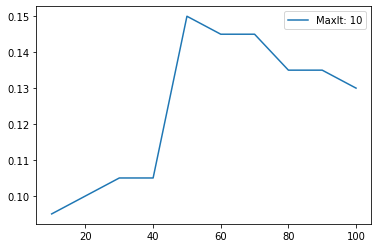

In [22]:
# TODO: plot the accuracies for each usage of maxIt
legend_labels = []
for i in range(len(maxIt_vals)):
    maxIt = maxIt_vals[i]
    val_accuracies = all_val_accuracies[i]
    num_wl = len(all_wl[i])
    plt.plot(np.arange(maxIt, num_wl * maxIt + 1, maxIt), val_accuracies)
    legend_labels.append(f"MaxIt: {maxIt}")
plt.legend(legend_labels)
plt.show()
    

In [ ]:
# Potential idea: maybe compare wall-clock time b/w CIFAR10 boosting and regular nn training to reach a certain accuracy threshold?

## Compare with other benchmarks? (i.e. other pretrained ensembles?)